In [2]:
import numpy as np
import matplotlib.pyplot as plt
from anthony.aes import sub_bytes, add_round_key

num_traces = 150
num_samples = 50000
num_key_bytes = 16

all_hamming_weights_per_box_1 = np.zeros((150, 256, 16), dtype=np.uint8)
all_hamming_weights_per_box_2 = np.zeros((150, 256, 16), dtype=np.uint8)
coeff_1 = np.zeros((16, 256))
coeff_2 = np.zeros((16, 256))

In [3]:
def hamming_weight(n):
    count = 0
    while n:
        count += n & 1
        n >>= 1
    return count

hamming_weights = np.array([hamming_weight(i) for i in range(256)])

In [4]:
plaintexts_1 = np.zeros((150, 16), dtype=int)

with open(f"data/dataset1/cleartext.txt", "r") as file:
	for i, line in enumerate(file):
		plaintexts_1[i] = np.array(line.strip().split(), dtype=int)

In [5]:
plaintexts_2 = np.zeros((150, 16), dtype=int)

with open(f"data/dataset2/cleartext.txt", "r") as file:
	for i, line in enumerate(file):
		plaintexts_2[i] = np.array(line.strip().split(), dtype=int)

In [6]:
all_traces_1 = np.zeros((16, 150, 50000), dtype=float)

for i in range(16):
        with open(f"data/dataset1/trace{i}.txt") as f:
            for t, line in enumerate(f):
                all_traces_1[i][t] = np.array(line.strip().split(), dtype=np.float64)

In [7]:
all_traces_2 = np.zeros((16, 150, 50000), dtype=float)

for i in range(16):
	with open(f"data/dataset2/trace{i}.txt") as f:
		for t, line in enumerate(f):
			all_traces_2[i][t] = np.array(line.strip().split(), dtype=np.float64)

In [8]:
all_clocks = np.zeros((16, 150, 50000), dtype=float)

for i in range(16):
	with open(f"data/dataset2/clock{i}.txt") as f:
		for t, line in enumerate(f):
			all_clocks[i][t] = np.array(line.strip().split(), dtype=np.float64)

In [9]:
for key_guess in range(256):
    key_guess_matrix = np.full((4, 4), key_guess, dtype=np.uint8)
    for tnum, in_data in enumerate(plaintexts_1):
        in_matrix = np.asarray(in_data, dtype=np.uint8).reshape(4, 4)

        added_key = add_round_key(in_matrix, key_guess_matrix)
        sub_out = sub_bytes(added_key, False).flatten()

        for byte_index in range(sub_out.shape[0]):
            all_hamming_weights_per_box_1[tnum][key_guess][byte_index] = hamming_weights[sub_out[byte_index]]

In [10]:
for key_guess in range(256):
    key_guess_matrix = np.full((4, 4), key_guess, dtype=np.uint8)
    for tnum, in_data in enumerate(plaintexts_2):
        in_matrix = np.asarray(in_data, dtype=np.uint8).reshape(4, 4)

        added_key = add_round_key(in_matrix, key_guess_matrix)
        sub_out = sub_bytes(added_key, False).flatten()

        for byte_index in range(sub_out.shape[0]):
            all_hamming_weights_per_box_2[tnum][key_guess][byte_index] = hamming_weights[sub_out[byte_index]]

In [11]:
coeffs_plot = np.zeros((256, 50000), dtype=np.float64)

In [12]:
maxes = np.zeros(256, dtype=np.float64)
for guess in range(256):
	guess_box_weights = all_hamming_weights_per_box_1[:, guess, 0] #! 1 or 2
	WxH = (all_traces_1[0].T * guess_box_weights).T #! 1 or 2
	EWxH = np.sum(WxH, axis=0)

	Ew = np.sum(all_traces_1[0], axis=0) #! 1 or 2

	Eh = np.sum(guess_box_weights)

	Ew2 = np.sum(np.square(all_traces_1[0]), axis=0) #! 1 or 2
	Ew_squared = np.square(Ew)  # constant

	Eh2 = np.sum(np.square(guess_box_weights), axis=0)
	Eh_squared = np.square(Eh)

	top = (150 * EWxH) - (Eh * Ew)
	bottom = np.sqrt((150 * Ew2) - Ew_squared) * np.sqrt((150 * Eh2) - Eh_squared)
	coeffs_plot[guess, :] = np.abs(top / bottom)
	maxes[guess] = np.max(np.abs(top / bottom))

In [26]:
master_key_1 = np.array([65, 117, 115, 116, 114, 97, 108, 111, 112, 105, 116, 104, 101, 99, 117, 115])

In [84]:
maxes = np.zeros(256, dtype=np.float64)
plt.figure(figsize=(8, 4))
def multi(box: int):
	print(f'{box=}')
	for guess in range(256):
		guess_box_weights = all_hamming_weights_per_box_1[:, guess, box] #! 1 or 2 AND BOX!!
		WxH = (all_traces_1[box].T * guess_box_weights).T #! 1 or 2
		EWxH = np.sum(WxH, axis=0)

		Ew = np.sum(all_traces_1[box], axis=0) #! 1 or 2

		Eh = np.sum(guess_box_weights)

		Ew2 = np.sum(np.square(all_traces_1[box]), axis=0) #! 1 or 2
		Ew_squared = np.square(Ew)  # constant

		Eh2 = np.sum(np.square(guess_box_weights), axis=0)
		Eh_squared = np.square(Eh)

		top = (150 * EWxH) - (Eh * Ew)
		bottom = np.sqrt((150 * Ew2) - Ew_squared) * np.sqrt((150 * Eh2) - Eh_squared)
		coeffs_plot[guess, :] = top / bottom

	# plt.plot(coeffs_plot[4], 'red', linewidth=0.5)
	plt.plot(coeffs_plot[master_key_1[box]], f'C{box}', linewidth=0.5)
	# plt.plot(coeffs_plot[6], 'blue', linewidth=0.5)

	plt.title('coefficient comparison')
	plt.xlabel('Index')
	plt.ylabel('Value')

<Figure size 800x400 with 0 Axes>

box=0
box=1
box=2
box=3
box=4
box=5
box=6
box=7
box=8
box=9
box=10
box=11
box=12
box=13
box=14
box=15


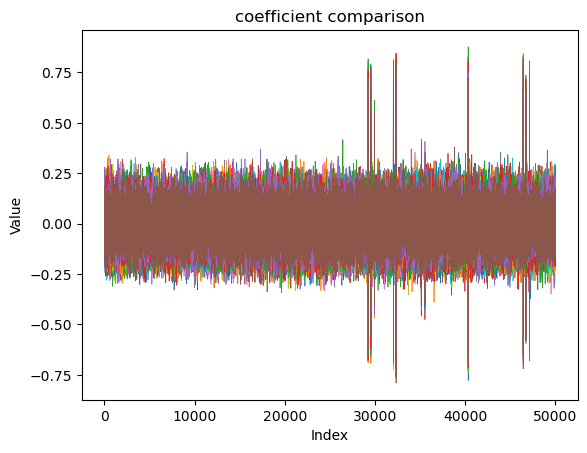

In [86]:
for i in range(16):
	multi(i)

plt.show()

In [74]:
np.where(coeffs_plot == np.max(coeffs_plot))

(array([115]), array([46435]))

In [93]:
all_clocks[15][0].shape

(50000,)

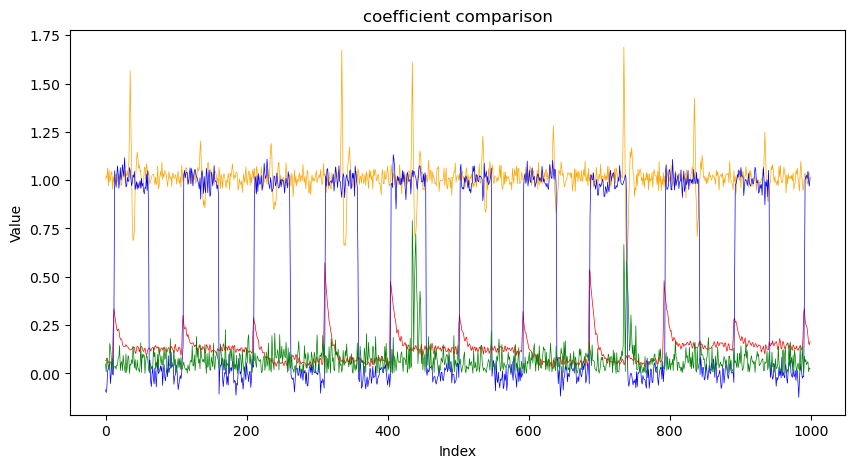

In [113]:
plt.figure(figsize=(10, 5)) #! 46435
plt.plot((all_traces_1[15][0] / 20000)[46000:47000], 'orange', linewidth=0.5)
plt.plot((all_traces_2[15][0])[46000:47000], 'red', linewidth=0.5)
plt.plot(all_clocks[15][0][46000:47000], 'blue', linewidth=0.5)
plt.plot(np.abs(coeffs_plot[master_key_1[15]])[46000:47000], 'green', linewidth=0.5)

plt.title('coefficient comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

### box 0
(array([65]), array([46435]))

### box 1
(array([117]), array([32335]))

### box 2
(array([115]), array([46435]))

### box 3
(array([116]), array([46435]))

### box 4
(array([114]), array([40335]))

### box 5
(array([97]), array([40335]))

### box 6
(array([108]), array([46435]))

### box 7
(array([111]), array([32335]))

### box 8
(array([112]), array([46435]))

### box 9
(array([105]), array([46435]))

### box 10
(array([116]), array([46435]))

### box 11
(array([104]), array([46435]))

### box 12
(array([101]), array([40335]))

### box 13
(array([99]), array([32335]))

### box 14
(array([117]), array([46435]))

### box 15
(array([115]), array([46435]))